In [40]:
# arima_module importation #

from arima_module import *

## Third Model : ARIMA model

#### **Introduction**

**ARIMA** stands for **Auto-Regressive Integrated Moving Average** and is a product of two models : 

- **Auto-Regressive model (AR)** parametized by a value p, which allows to predict the future value of a time series through a regression on its last p values.

- **Moving Average model (MA)** parametized by a value q, which instead of using past forecast values uses past forecast errors in a regression-like model and aim to improve the model's forecasts by knowing how far off our prediction from yesterday was compared to the actual value. The forcasts are made based on the last q periods before the current period.


**ARIMA** model have a last parameter, the order of differenciation d, which is the number of times we must differenciate the time series to make it stationnary. **Stationnary is a must-have feature** in our time series that allows us to apply the two components (AR, MA) of the ARIMA model.


To sum up, we aim to predict the close cotation by using an **ARIMA(p,d,q)** model. From now on, we focus on the determination of the parameters **p,d,q**.

#### **Loading and visualizing the data**

In [29]:
# Use the API to load the data #

symbol = 'BTC/USD'
interval = '1day'
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 00:00:00'

In [ ]:
# Fast checking the data values #

data = load_data(symbol, start_date, end_date, interval)


def add_arima_indicators(data,price, period) :

    ma = data[str(price)].rolling(window=period).mean().dropna()
    mstd = data[str(price)].rolling(window=period).std().dropna()
    data = pd.DataFrame(data.loc[period-1:])

    data['ma'] = ma
    data['mstd'] = mstd
    
    return data.reset_index().drop('index', axis=1)

data = add_arima_indicators(data, "close", period = 14) 

data.head(n = 10)

In [46]:
#We can visualize the data along with its moving statistics. A  stationnary time series must have these features constants in time #


def arima_viz_with_indicator(data, symbol, interval) :

    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=['Candles', 'Moving Average', 'Moving Std'])
    candle = go.Candlestick(x=data['datetime'],
                                        open=data['open'],
                                        high=data['high'],
                                        low=data['low'],
                                        close=data['close'], name = "Price")

    fig.add_trace(candle, row=1, col =1)


    ma_trace=go.Scatter(x=data['datetime'], y=data['ma'], mode='lines', name="Moving Average", yaxis='y2')

    fig.add_trace(ma_trace, row=2, col=1)

    mstd_trace=go.Scatter(x=data['datetime'], y=data['mstd'], mode='lines', name="Moving Std", yaxis='y3')

    fig.add_trace(mstd_trace, row=3, col=1)

    
    fig.update_layout(title='Cotation of ' + str(symbol) + ' per ' + str(interval) ,
                  xaxis_title='Date',
                  yaxis_title='Price in USD',
                  xaxis_rangeslider_visible=False)



    fig.show()

arima_viz_with_indicator(data,symbol, interval)

- We observe a downward trend and a non-constant variance in the previous plots. Our series is non-stationnary

#### **Stationnarity and differenciating order d**

To achieve stationnarity we will need to differenciate our data at least once (d 0).

Two tests can help us confirm wether the series is stationnary or not :

- The **Augmented Dicky Fuller Test (ADF Test)** : H0 = The series is non-stationary. The more negative the ADF number is, the more prominent the rejection of the null hypothesis that the time series is non-stationary.

- The **Kwiatkowski–Phillips–Schmidt–Shin (KPSS)**: H0 = The series is stationary. The higher the test statistic, the more prominent the rejection of the null hypothesis that the series is stationary.


Let's perform an example on the original series.

In [50]:
def adf_test(data, price) : 
    result = adfuller(data[str(price)])
    adf_stat = result[0]
    p_value = result[1]

    print('ADF statistic : %f' % adf_stat)
    print('p-value : %f' % p_value)

    return adf_stat, p_value


def kpss_test(data, price) : 

    print("Results of KPSS Test:")
    kpsstest = kpss(data[str(price)], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

adf_test(data, "close")
kpss_test(data, 'close')

ADF statistic : -1.573275
p-value : 0.497003
Results of KPSS Test:
Test Statistic            0.331507
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


/tmp/ipykernel_173083/468981977.py:15: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The ADF test failed to reject the null hypothesis while the KPSS rejects its null hypothesis with a very small p-value. It firmly confirms the non-stationnarity of the time series

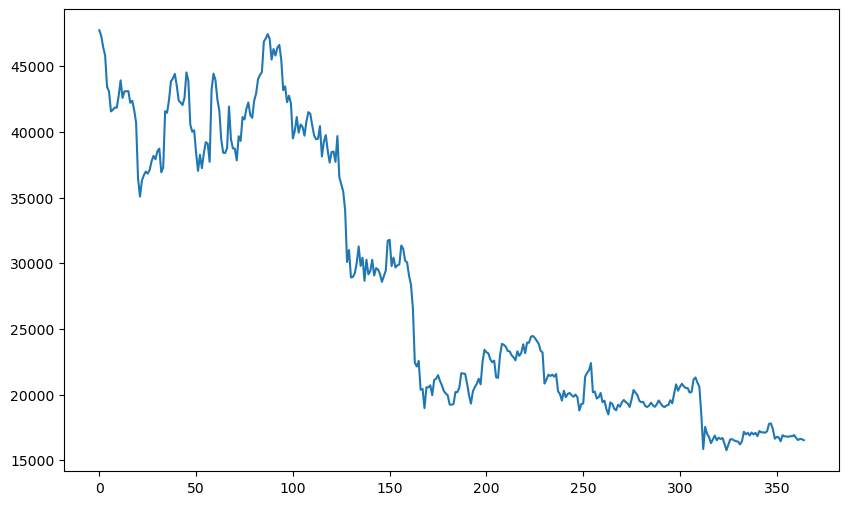

In [31]:
fig, ax = plt.subplots(figsize=(10,6), dpi =100)
ax.plot(data.index, data["close"])

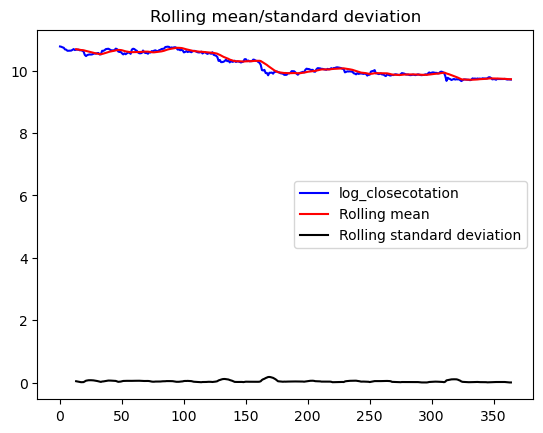

In [32]:
# Visualize the data to assess stationnarity #
def 
period = 14
rolling_mean = data["log_close"].rolling(window=period).mean()
rolling_std = data["log_close"].rolling(window=period).std()
    
# Plot comparing time series and its moving statistics
original = plt.plot(data["log_close"], color='blue', label= "log_close" + 'cotation')
mean = plt.plot(rolling_mean, color='red', label='Rolling mean')
std = plt.plot(rolling_std, color='black', label='Rolling standard deviation')
plt.legend(loc='best')
plt.title('Rolling mean/standard deviation')
plt.show(block=False)

#### Before applying the ARIMA prediction model, we need to check if the series is stationnary
###### For this sake, we first plot the moving average and standard deviation on the last 14 days
###### We need them to be approximately constant in time.
###### Then we run the ADF test on the time series. 
###### We want the ADF statistic of the time series to be as close as possible to the criticals values returned by the test and its p-value to be small 

In [25]:
arima_module.stationnarity_fast_check(data, close, 14)

NameError: name 'close' is not defined

#### Observations

###### While the standard deviation gives us hope about being constant, the rolling mean seems pretty much instable
###### The ADF test results shows that the series is pretty far from being stationnary

##### To lower the variation width we can focus of the log of the close cotation and see the results on this new series 


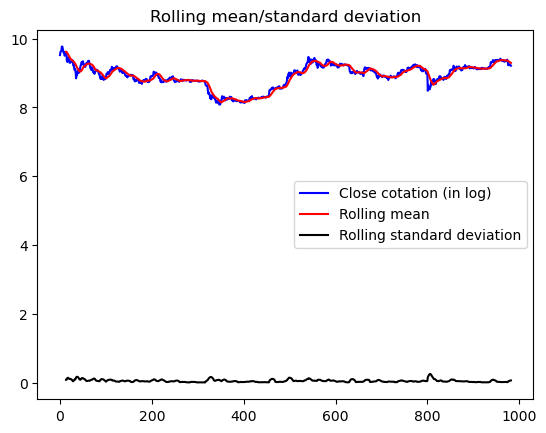

ADF statistics : -2.3667527195738494
p-value : 0.15134087720706035
Critical values :
	1%: -3.4370403176323214
	5%: -2.8644937368358425
	10%: -2.5683427207413576


In [5]:
period = 14
rolling_mean = np.log(data['close']).rolling(window=period).mean()
rolling_std = np.log(data['close']).rolling(window=period).std()
    
# Plot comparing time series and its moving statistics
original = plt.plot(np.log(data['close']), color='blue', label='Close cotation (in log)')
mean = plt.plot(rolling_mean, color='red', label='Rolling mean')
std = plt.plot(rolling_std, color='black', label='Rolling standard deviation')
plt.legend(loc='best')
plt.title('Rolling mean/standard deviation')
plt.show(block=False)
        
# Dickey–Fuller's Test :
result = adfuller(np.log(data['close']))
print('ADF statistics : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))




##### The log transformatiion makes the stationnarity hypothesis much more plausible at sight and the ADF tests results looks corrects as though the p-value is worst than without the log  

##### We will try a third approach wich consists in substracting the rolling mean to the close cotation value and only focus on deviations around this value. 

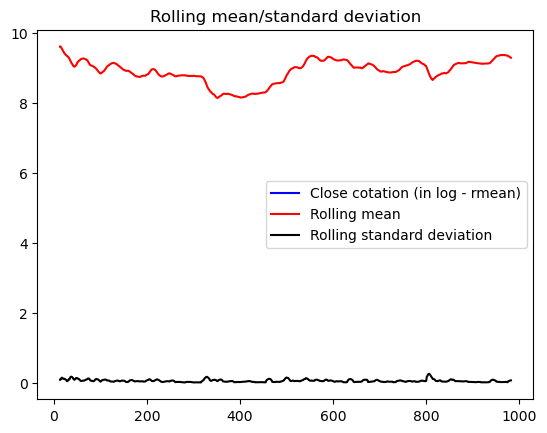

MissingDataError: exog contains inf or nans

In [8]:
period = 14
rolling_mean = np.log(data['close']).rolling(window=period).mean()
data['centered_log_close'] = (np.log(data['close'])-rolling_mean).dropna(inplace=True)
rolling_std = np.log(data['close']).rolling(window=period).std()
    
# Plot comparing time series and its moving statistics
original = plt.plot(data['centered_log_close'], color='blue', label='Close cotation (in log - rmean)')
mean = plt.plot(rolling_mean, color='red', label='Rolling mean')
std = plt.plot(rolling_std, color='black', label='Rolling standard deviation')
plt.legend(loc='best')
plt.title('Rolling mean/standard deviation')
plt.show(block=False)

# Dickey–Fuller's Test :
result = adfuller(data['centered_log_close'])
print('ADF statistics : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value)) 





##### This approach does not upgrade the results we obtain with the log transformation 
##### We will stick at applying the ARIMA prediction model on to the log of the close cotation

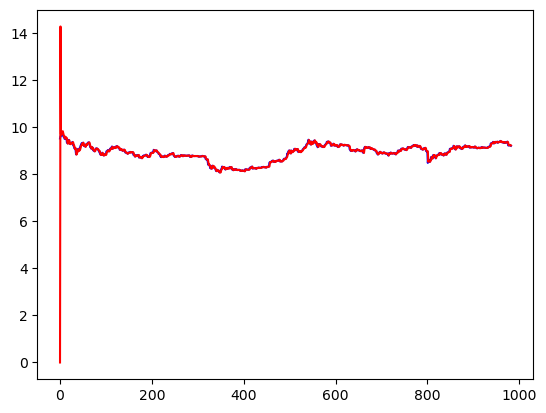

In [15]:
from statsmodels.tsa.arima.model import ARIMA
data['log_close'] = np.log(data['close'])
model = ARIMA(data['log_close'], order=(2,2,1))
results = model.fit()
plt.plot(data['log_close'], color = 'blue')
plt.plot(results.fittedvalues, color='red')

In [30]:
from statsmodels.tsa.arima.model import ARIMA
 
model = ARIMA(data['log_close'], order=(2,1,0))
model_fit = model.fit()
model_fit

                               SARIMAX Results                                
Dep. Variable:              log_close   No. Observations:                  983
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1732.416
Date:                Tue, 12 Dec 2023   AIC                          -3458.831
Time:                        10:24:04   BIC                          -3444.162
Sample:                             0   HQIC                         -3453.251
                                - 983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0921      0.022     -4.202      0.000      -0.135      -0.049
ar.L2          0.0707      0.030      2.368      0.018       0.012       0.129
sigma2         0.0017   2.24e-05     76.711      0.0

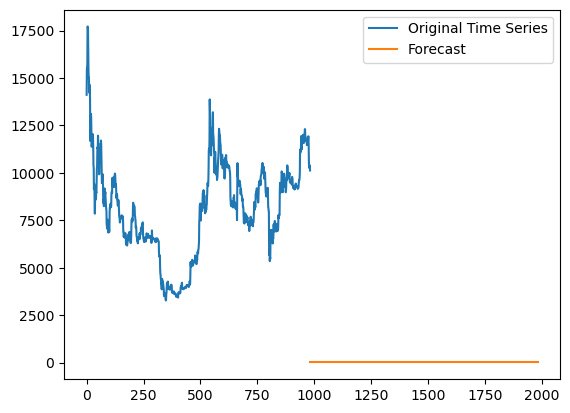

In [31]:
# Convertir la colonne log_close en série temporelle si ce n'est pas déjà le cas


#time_series = pd.Series(data['log_close'].values, index=data['date_column'])

# Si votre série temporelle est déjà une Time Series, vous pouvez directement utiliser la ligne suivante
# time_series = data['log_close']

# Créer le modèle ARIMA
ordre = (2, 1, 0)  
model = ARIMA(data['log_close'],exog = None, order=ordre)

result = model.fit()
print(result.summary())

# Prévoir les valeurs futures
forecast_steps = 1000  # Remplacez 10 par le nombre d'étapes que vous souhaitez prévoir
forecast = result.forecast(steps=forecast_steps)

# Afficher le résultat
print(forecast)

# Tracer la série temporelle originale et les prévisions
plt.plot(data['high'], label='Original Time Series')
plt.plot(range(len(data['high']), len(data['high']) + forecast_steps), forecast, label='Forecast')
plt.legend()
plt.show()


In [26]:
from pmdarima import auto_arima

model = auto_arima(data['log_close'], seasonal=False, suppress_warnings=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  983
Model:               SARIMAX(2, 1, 0)   Log Likelihood                1732.416
Date:                Tue, 12 Dec 2023   AIC                          -3458.831
Time:                        10:22:53   BIC                          -3444.162
Sample:                             0   HQIC                         -3453.251
                                - 983                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0921      0.022     -4.202      0.000      -0.135      -0.049
ar.L2          0.0707      0.030      2.368      0.018       0.012       0.129
sigma2         0.0017   2.24e-05     76.711      0.0